# FaceWord Notebook 
### *- Laurits and Elisius*
This is a notebook for working through the EEG data from the face-word experiment

In [2]:
# Installing packages in the notebook
%pip install mne
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Loading packages:
import mne
import numpy as np
import pandas as pd
import os
import matplotlib
%matplotlib inline

from statsmodels.stats.multitest import multipletests as multi

# Fixing data:
There is a problem with the timestamps, we export a csv file to fix the problems in R (im more adept in R)

In [7]:
# Reading files with a hard coded data location
raw = mne.io.read_raw_brainvision("./Data/own_group8.vhdr", eog= ("EOG1", "EOG2"))
raw.load_data()


Extracting parameters from ./Data/own_group8.vhdr...
Setting channel info structure...
Reading 0 ... 652999  =      0.000 ...   652.999 secs...


<RawBrainVision | own_group8.eeg, 32 x 653000 (653.0 s), ~159.5 MB, data loaded>

In [8]:
# Save the timestamps as a csv file for manipulation in R
timestamps = mne.events_from_annotations(raw)[0]
np.savetxt("Fixing_Timestamps/timestamps.csv", timestamps, delimiter=",")
# Import the manipulated timestamps from R
# Read the CSV file into a pandas DataFrame
cleaned_events_df = pd.read_csv('Fixing_Timestamps/Cleaned_Timestamps.csv')

# Convert the DataFrame to a numpy array
cleaned_events = np.array( cleaned_events_df )



Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S121', 'Stimulus/S122', 'Stimulus/S123', 'Stimulus/S211', 'Stimulus/S212', 'Stimulus/S213', 'Stimulus/S214', 'Stimulus/S215', 'Stimulus/S221', 'Stimulus/S222', 'Stimulus/S223']


In [9]:
# Resaved events with dtype = np.int32 to avoid error in mne 
cleaned_events = np.array( cleaned_events, dtype = np.int32 )
cleaned_events

array([[     247374,           0,         223],
       [     248976,           0,           2],
       [     250013,           0,         212],
       ...,
       [     624043,           0,           1],
       [     625079,           0,         222],
       [-2147483648, -2147483648, -2147483648]])

Using matplotlib as 2D backend.


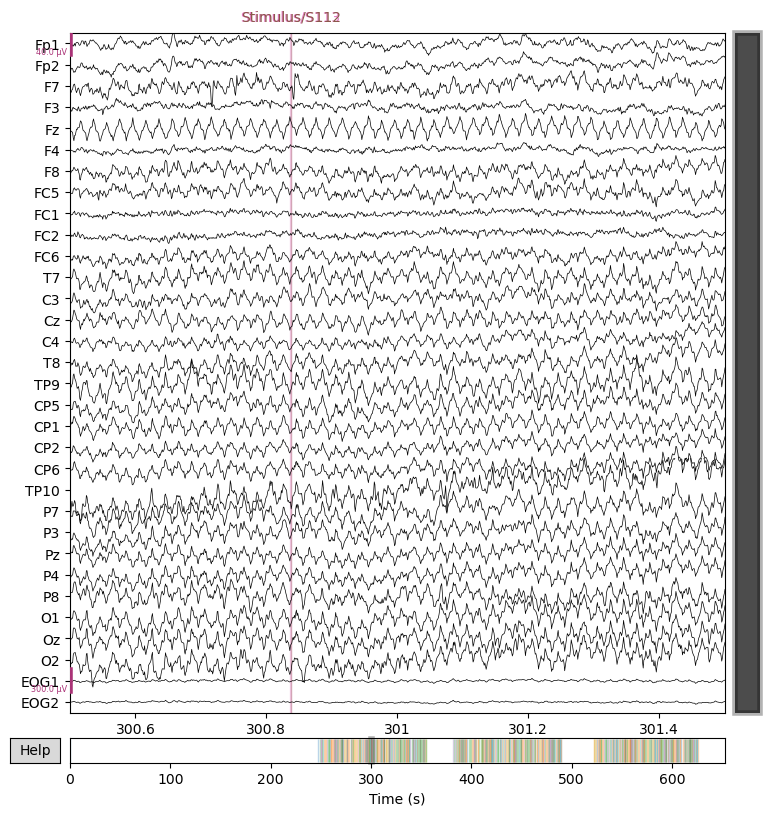

In [10]:
# Selecting only EEG and stimulus data & plotting raw data
raw.plot(n_channels=32, duration=1, start = 300.5);

In [11]:

#Specify the channel locations using standard_montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

<RawBrainVision | own_group8.eeg, 32 x 653000 (653.0 s), ~159.5 MB, data loaded>

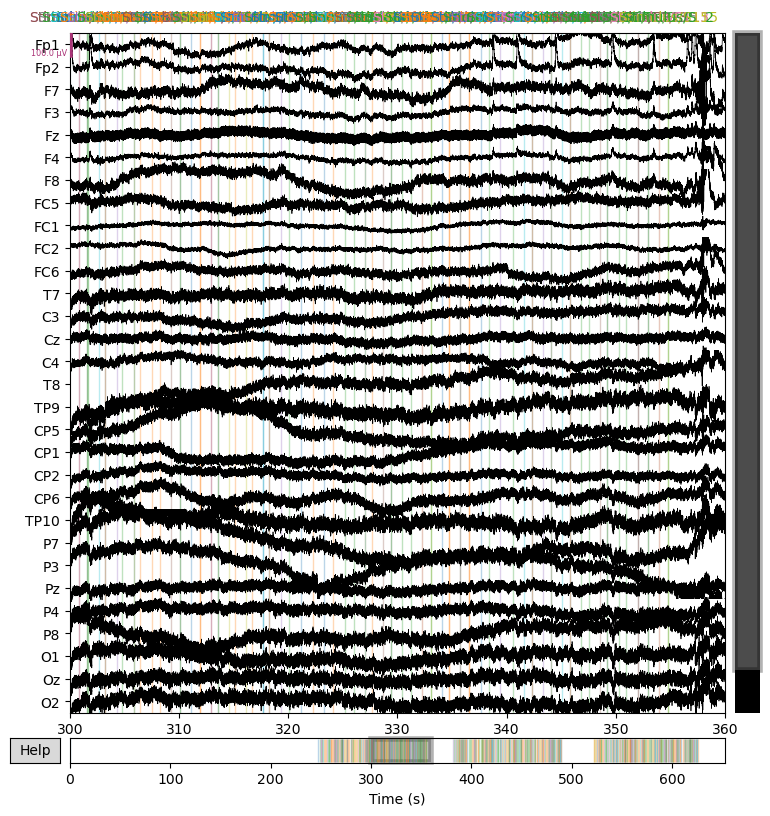

Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.9s finished


In [12]:
# Try to find bad channels using ICA:
raw.plot(n_channels=30, duration=60, start = 300, scalings=dict(eeg=50e-6));
#ICA
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')

# Setting a temporary very HIGH rejection threshold to avoid rejection of all channels
raw_fit = raw.copy().filter(1, None)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 15 components
Fitting ICA took 19.2s.


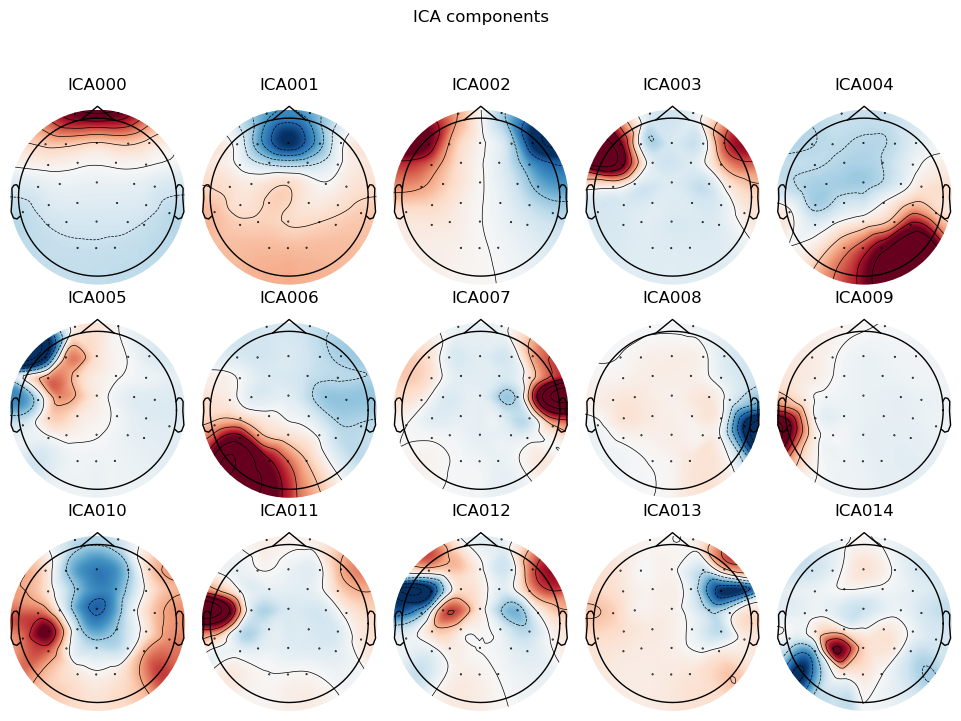

In [13]:
# set up and fit the ica with 800 iterations with a random seed at 7
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data# n
ica = mne.preprocessing.ICA(n_components=0.95, random_state=7, max_iter=800)
ica.fit(raw_fit)
ica.plot_components();

Creating RawArray with float64 data, n_channels=17, n_times=653000
    Range : 0 ... 652999 =      0.000 ...   652.999 secs
Ready.


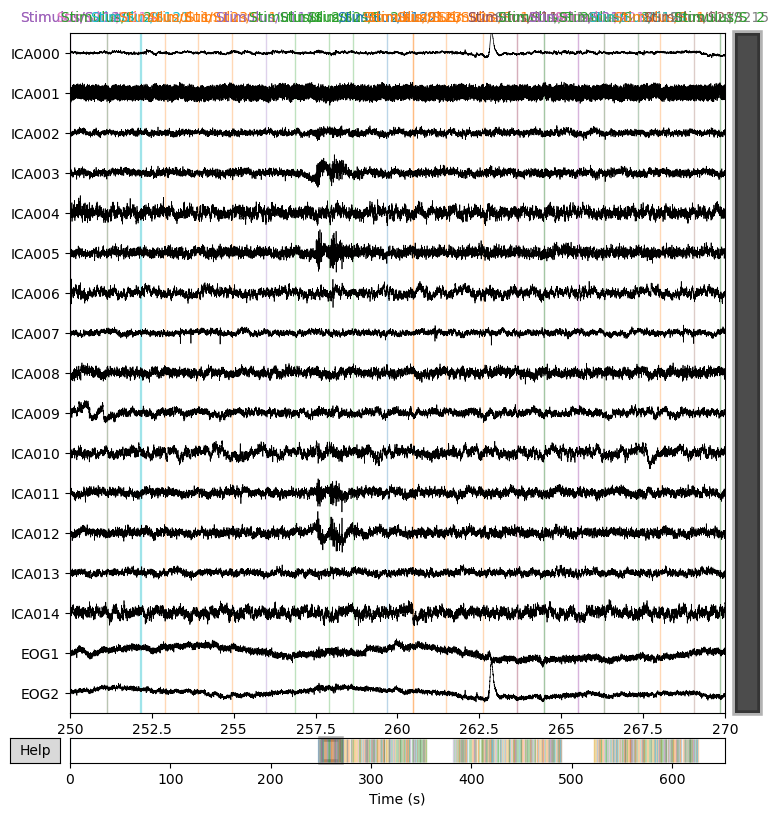

In [14]:
# Visually investigate the components after 250 seconds
ica.plot_sources(raw_fit, start = 250);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
326 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
326 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
326 matching events found
No baseline correction applied
0 projection items activated


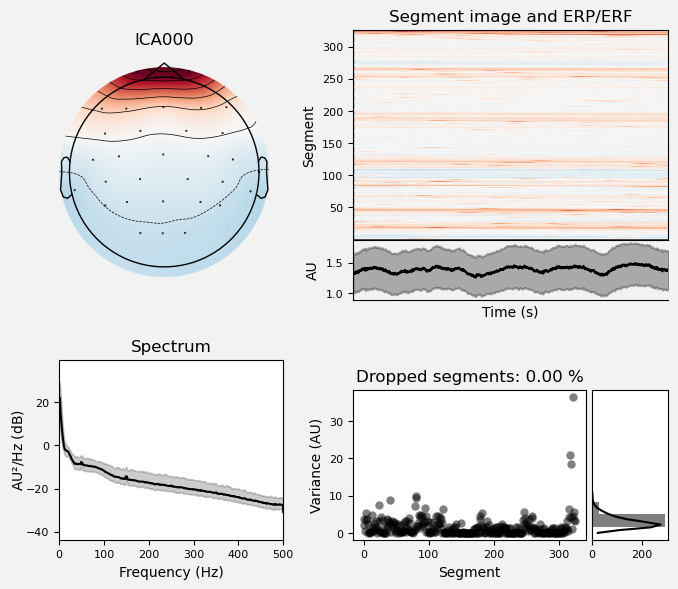

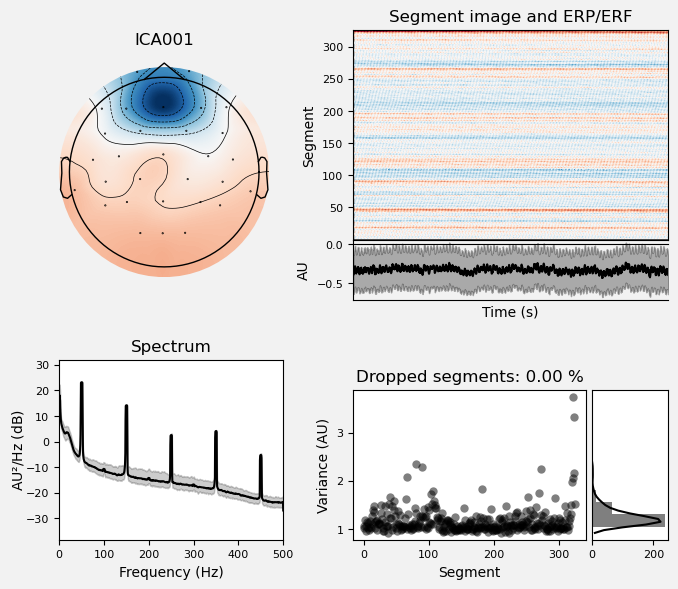

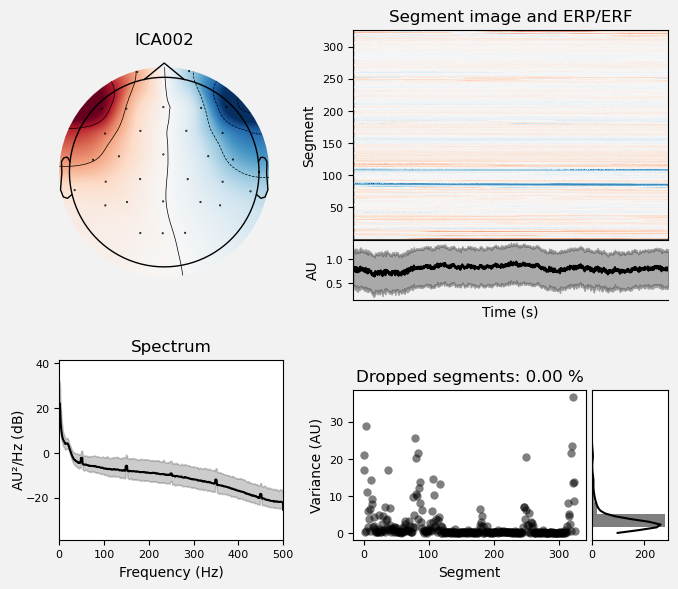

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


<RawBrainVision | own_group8.eeg, 32 x 653000 (653.0 s), ~159.5 MB, data loaded>

In [15]:
ica.exclude = [0,1,2] # setting the exclude argument to the noise components
ica.plot_properties(raw, picks=ica.exclude); # plotting the components that will be excluded (sanity check, did we index the right ones?)

ica.apply(raw)

In [16]:
#No obvious bad channels found

#lowpass filter
raw.filter(None, 40)
#Highpass filter
raw.filter(0.1, None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.8s finished


<RawBrainVision | own_group8.eeg, 32 x 653000 (653.0 s), ~159.5 MB, data loaded>

In [17]:
# it seems the intense amplitude and frequenzy of the Fz makes the data un-interprable
#raw.info['bads'] = ['Fz']
#raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')


#### COMMENTED OUT as this was not necessarry/warranted after ICA

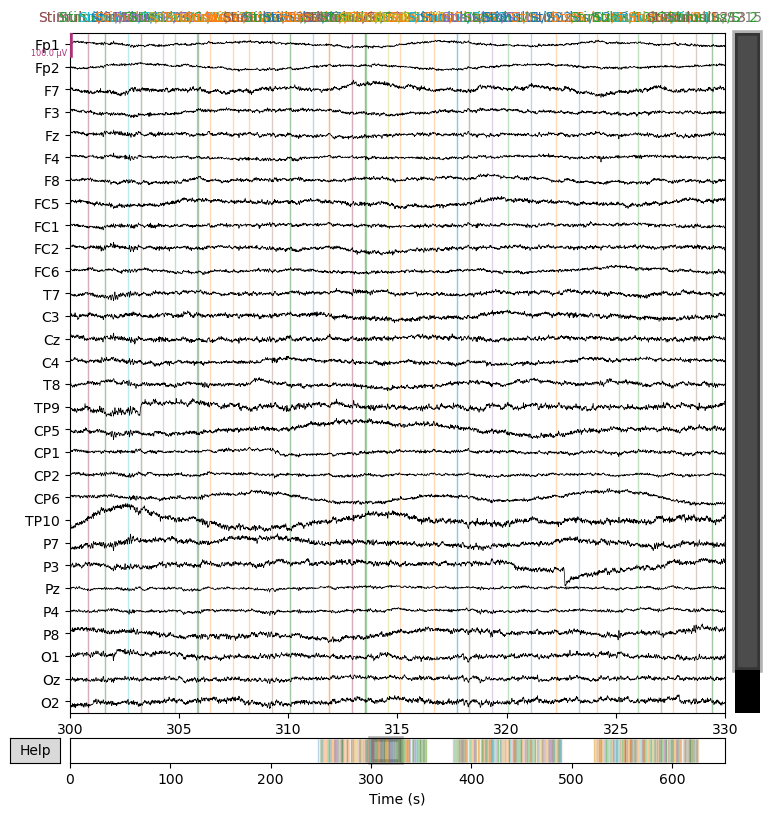

In [18]:
#Plotting after filtering:

raw.plot(n_channels=30, duration=30, start=300, scalings=dict(eeg=50e-6));

In [19]:
# Set event ID's
event_id = {
    'Changed/Familliar/0' : 221,
    'Changed/Familliar/90' : 222,
    'Changed/Familliar/180' : 223,
    'Changed/Unfamilliar/0' : 211,
    'Changed/Unfamilliar/90' : 212,
    'Changed/Unfamilliar/180' : 213,
    'Unchanged/Familliar/0' : 121,
    'Unchanged/Familliar/90' : 122,
    'Unchanged/Familliar/180' : 123,
    'Unchanged/Unfamilliar/0' : 111,
    'Unchanged/Unfamilliar/90' : 112,
    'Unchanged/Unfamilliar/180' : 113,
    'Response_Changed' : 1,
    'Response_Unchanged' : 2,

}

C:\Users\lauri\AppData\Local\Temp\ipykernel_23508\3434262602.py:5: RuntimeWarning: event -2147483648 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);
C:\Users\lauri\AppData\Local\Temp\ipykernel_23508\3434262602.py:5: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);


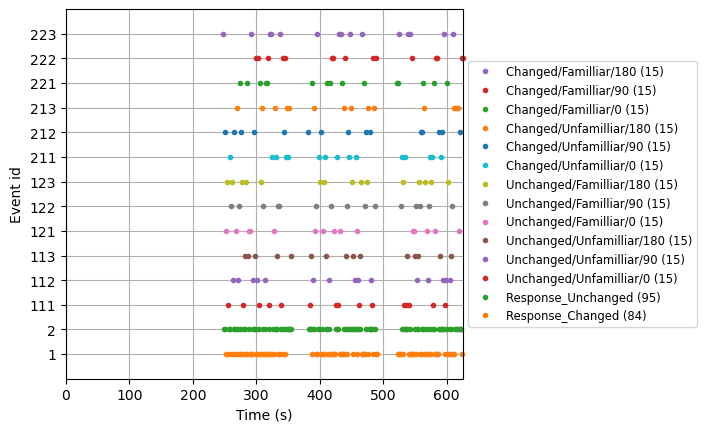

In [20]:
# Plot events :))
events = cleaned_events


mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);

# Creating epochs, resampling and saving for:
## EEG_OWN_STATS.ipynb

In [42]:

# Define time window for epochs:
tmin, tmax = -0.1, 0.7
#create the rejection dictionary (how big the difference between a low and high can be in a (unrejected) epoch)
# reject criterion of 150 microvolts
reject = {'eeg': 150e-6} 
# Create epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, 
                    reject=reject, preload=True)

# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)


#saving our EPOCHS as an object
# epochs_resampled.save('./Data/Epochs/thatcher_epochs.fif')
epochs_resampled

Not setting metadata
359 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 359 events and 801 original time points ...
    Rejecting  epoch based on EEG : ['TP9']
1 bad epochs dropped


Number of events,358
Events,Changed/Familliar/0: 15Changed/Familliar/180: 15Changed/Familliar/90: 15Changed/Unfamilliar/0: 15Changed/Unfamilliar/180: 15Changed/Unfamilliar/90: 15Response_Changed: 84Response_Unchanged: 94Unchanged/Familliar/0: 15Unchanged/Familliar/180: 15Unchanged/Familliar/90: 15Unchanged/Unfamilliar/0: 15Unchanged/Unfamilliar/180: 15Unchanged/Unfamilliar/90: 15
Time range,-0.100 – 0.696 sec
Baseline,-0.100 – 0.000 sec


# ERP analysis
The data has been preprocessed and is ready to be analyzed-

In [78]:
# NOT evoked variabled 
all_changed = epochs['Changed']
all_unchanged = epochs['Unchanged']

# Evoked variables
## Changed vs unchaged
all_changed_evoked = epochs['Changed'].average()
all_unchanged_evoked = epochs['Unchanged'].average()

# INTERACTIONS
# Changed vs Unchanged X Inversion effect
## creating for changed vs unchanged for each rotation
changed_0 = epochs['Changed/0'].average()
changed_90 = epochs['Changed/90'].average()
changed_180 = epochs['Changed/180'].average()

unchanged_0 = epochs['Unchanged/0'].average()
unchanged_90 = epochs['Unchanged/90'].average()
unchanged_180 = epochs['Unchanged/180'].average()

# Familiar vs Unfamiliar X Changed vs Unchanged X Inversion effect
## creating for famiar vs unfamiliar interacting with inverse effect

## Familiar
changed_0_familiar = epochs['Changed/0/Familliar'].average()
changed_90_familiar = epochs['Changed/90/Familliar'].average()
changed_180_familiar = epochs['Changed/180/Familliar'].average()

unchanged_0_familiar = epochs['Unchanged/0/Familliar'].average()
unchanged_90_familiar = epochs['Unchanged/90/Familliar'].average()
unchanged_180_familiar = epochs['Unchanged/180/Familliar'].average()

## Unfamiliar
changed_0_unfamiliar = epochs['Changed/0/Unfamilliar'].average()
changed_90_unfamiliar = epochs['Changed/90/Unfamilliar'].average()
changed_180_unfamiliar = epochs['Changed/180/Unfamilliar'].average()

unchanged_0_unfamiliar = epochs['Unchanged/0/Unfamilliar'].average()
unchanged_90_unfamiliar = epochs['Unchanged/90/Unfamilliar'].average()
unchanged_180_unfamiliar = epochs['Unchanged/180/Unfamilliar'].average()

In [44]:
# 
# #all_changed.plot_image(picks=('Oz'));
# #all_unchanged.plot_image(picks=('Oz'));

# Evoked Plot join

No projector specified for this dataset. Please consider the method self.add_proj.


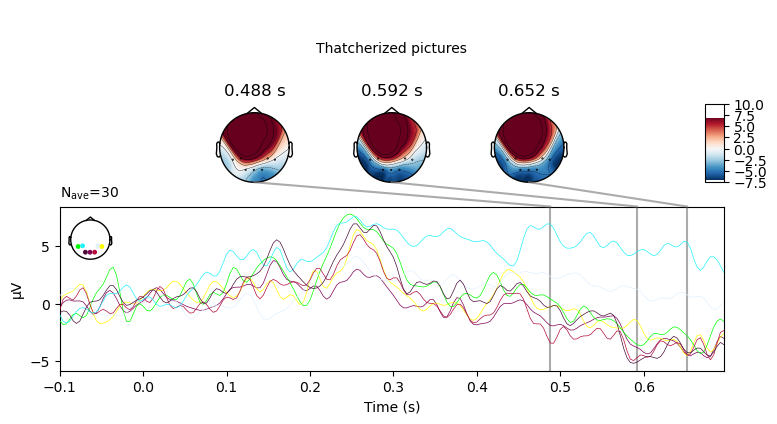

No projector specified for this dataset. Please consider the method self.add_proj.


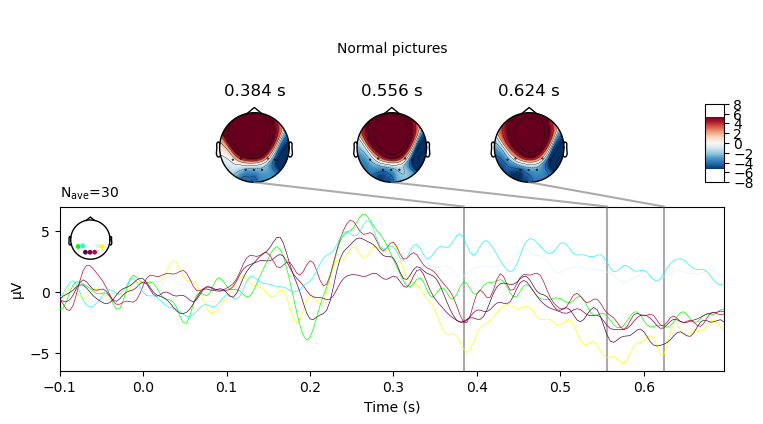

In [45]:
## Plotting ##
Thatcherized_plot = changed_90.plot_joint(picks=['P3', 'P7', "P4", "P8", "O1", "Oz", "O2"], title = "Thatcherized pictures");

Unthatcherized_plot = unchanged_90.plot_joint(picks=['P3', 'P7', "P4", "P8", "O1", "Oz", "O2"], title = "Normal pictures");

# Compare Evokeds

combining channels using "gfp"
combining channels using "gfp"


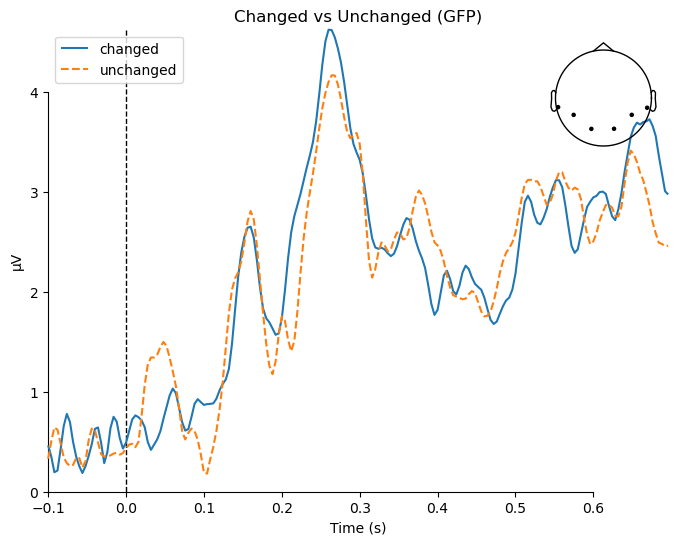

In [81]:
mne.viz.plot_compare_evokeds(dict(changed=all_changed_evoked, unchanged=all_unchanged_evoked),
                             linestyles=dict(changed ='solid', unchanged ='dashed'),
                             legend='upper left', show_sensors='upper right',
                             picks=["TP9", "TP10", "P7", "P8", "O1", "O2"], title="Changed vs Unchanged");


combining channels using "mean"
combining channels using "mean"


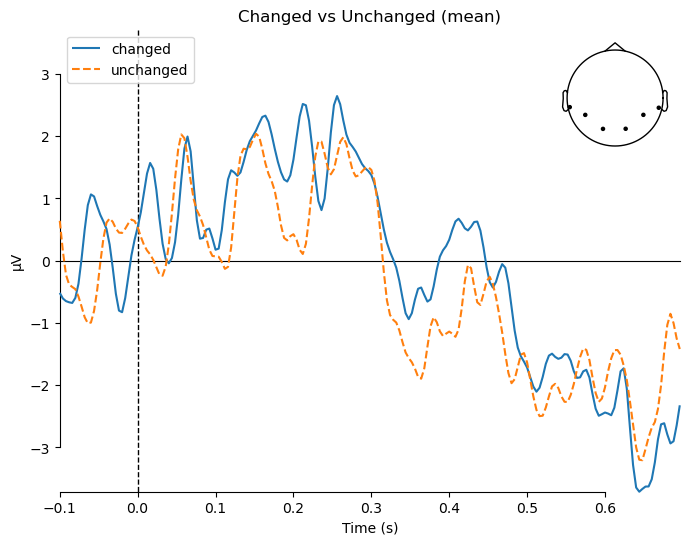

In [80]:
mne.viz.plot_compare_evokeds(dict(changed=changed_0, unchanged=unchanged_0),
                             linestyles=dict(changed ='solid', unchanged ='dashed'),
                             legend='upper left', show_sensors='upper right',
                             picks=["TP9", "TP10", "P7", "P8", "O1", "O2"], title="Changed vs Unchanged", combine='mean');
